In [1]:
# For moving through folders and paths
import os
from pathlib import Path

# Useful libraries
import datetime
import pandas as pd
import numpy as np
import math
import IPython
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import accuracy_score
from kerastuner.tuners import RandomSearch
import kerastuner as kt

# Load the TensorBoard notebook extension
%load_ext tensorboard

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.2.0
Num GPUs Available:  1


In [2]:
# Assign path
rt = Path(os.getcwd())  # Get current working directory
rt = rt.parents[0]  # Go one level up in the current working directory

X_train = []
X_cv = []
X_tst = []

y_train = []
y_cv = []
y_tst = []

# Load data
for gest in np.arange(0, 4):
    file2read = 'Reformatted EMG Data/gesture_' + str(gest) + '.csv'
    df = np.array(pd.read_csv(rt/file2read))

    # Get total number of windows
    win_size = 40  # Myo sampling rate is 200 Hz thus, 200 ms of data equals to 40 samples.
    numwin = df.shape[0] // win_size
    nsignals = 8  # No. of channels. The Myo armband has 8

    dat_X = df[:, :nsignals]
    y = df[:numwin, -1]
    dat_X = np.reshape(dat_X, (numwin, win_size, nsignals))

    #################################################
    # Create txt files with the index order for splitting the data
    # Not to be used again
    #################################################
    # a = np.arange(numwin)
    # np.random.shuffle(a)
    # a = a.reshape(1, -1)
    #
    # a_file = open('index_gest_' + str(gest) + '.txt', "w")
    # for row in a:
    #     np.savetxt(a_file, row)
    #
    # a_file.close()
    #################################################
    original_array = np.loadtxt('index_gest_' + str(gest) + '.txt').reshape(1, numwin).astype(int)
    a = tuple(original_array)

    dat_X[:] = dat_X[a]

    # Train, CV, test splits (60/20/20)
    tst_size = math.floor(numwin*0.2)
    tr_X = dat_X[:numwin-tst_size*2]
    cv_X = dat_X[numwin-(tst_size*2):numwin-(tst_size*2)+tst_size]
    tst_X = dat_X[numwin-(tst_size*2)+tst_size:]

    X_train = np.append(X_train, tr_X)
    X_cv = np.append(X_cv, cv_X)
    X_tst = np.append(X_tst, tst_X)
    y_train = np.append(y_train, y[:tr_X.shape[0]])
    y_cv = np.append(y_cv, y[:cv_X.shape[0]])
    y_tst = np.append(y_tst, y[:tst_X.shape[0]])

In [3]:
# Reshape data and reshuffle it
# Training data
aux = np.arange(y_train.shape[0])
np.random.shuffle(aux)
X_train = X_train.reshape(-1, win_size, nsignals)
X_train[:] = X_train[aux]
y_train[:] = y_train[aux]

# Cross_validation data
aux = np.arange(y_cv.shape[0])
np.random.shuffle(aux)
X_cv = X_cv.reshape(-1, win_size, nsignals)
X_cv[:] = X_cv[aux]
y_cv[:] = y_cv[aux]

# Testing data
aux = np.arange(y_tst.shape[0])
np.random.shuffle(aux)
X_tst = X_tst.reshape(-1, win_size, nsignals)
X_tst[:] = X_tst[aux]
y_tst[:] = y_tst[aux]

# one hot encode the outputs for the softmax layer
y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)
y_tst = to_categorical(y_tst)

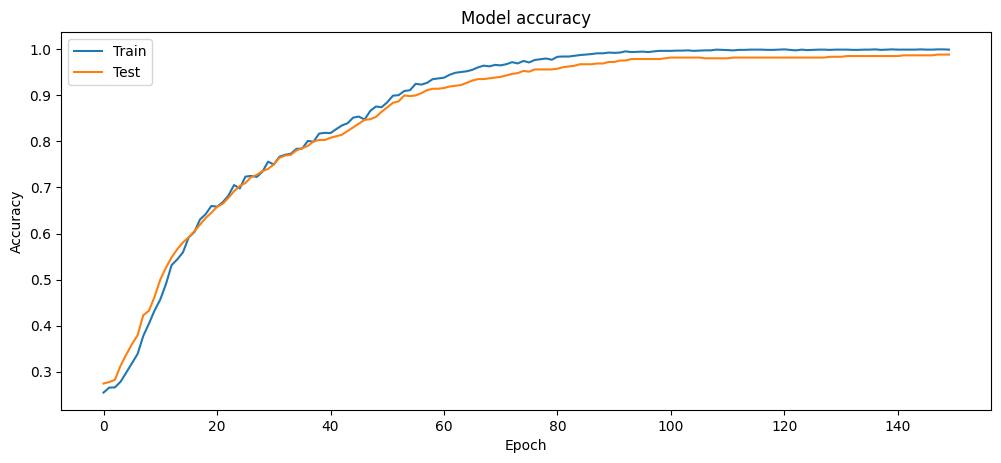

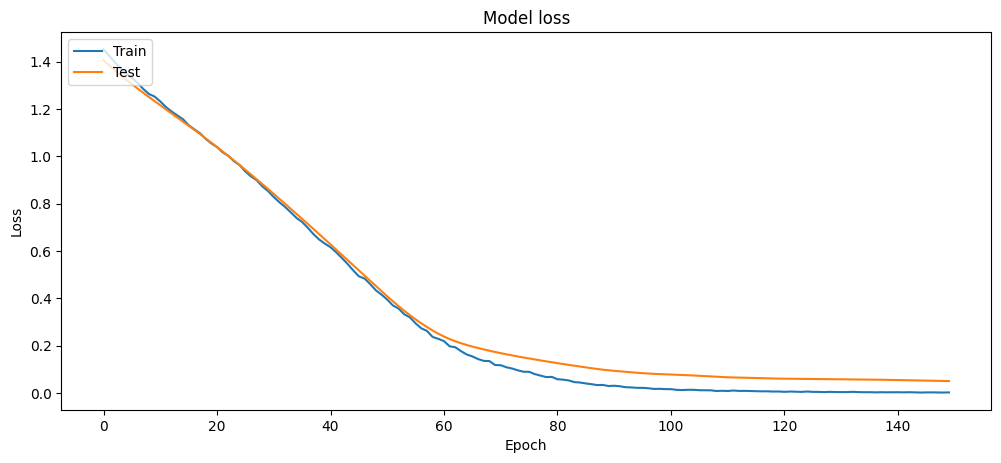

0.9903225806451613


In [4]:
# LSTM Model
model = Sequential()

# Set the value 'return_sequences' to true if want to add another LSTM layer
# When adding another LSTM layer, we don't have to specify the input shape
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# The dropout layer is optional
model.add(Dropout(0.2))

# Non LSTM layer (normal hidden layer)
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
batch_size = X_train.shape[0]  # Max batch_size = number of training samples
history = model.fit(X_train, y_train, epochs=150, batch_size=batch_size, verbose=0,
                    validation_data=(X_cv, y_cv), shuffle=False)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predict the test data
y_pred = model.predict(X_tst)

# Reverse one-hot encoding
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_true = [np.argmax(y, axis=None, out=None) for y in y_tst]

acc = accuracy_score(y_true, y_pred)
print(acc)

### Hyperparameter Tuning

In [5]:
def build_model(hp):
    # LSTM Model
    model = Sequential()    
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Tune: # Hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        # Tune: # Neurons per layer
        model.add(Dense(units=hp.Int('units_' + str(i), 50, 250, 50),
                       activation=hp.Choice(name='activation function', values=['relu','elu'])))
        # Tune: Dropout rate
        model.add(Dropout(rate=hp.Float('dropout', 0.15, 0.3, 0.03)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='tuning')

In [7]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [9]:
tuner.search(X_train, y_train,
             epochs=150,
             validation_data=(X_cv, y_cv),
             callbacks=[tensorboard_callback, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [20]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 5)[2]

In [21]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, 
                    y_train, 
                    epochs=150,
                    validation_data = (X_cv, y_cv), 
                    verbose=0)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11800     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 17,304
Trainable params: 17,304
Non-trainable params: 0
_________________________________________________________________


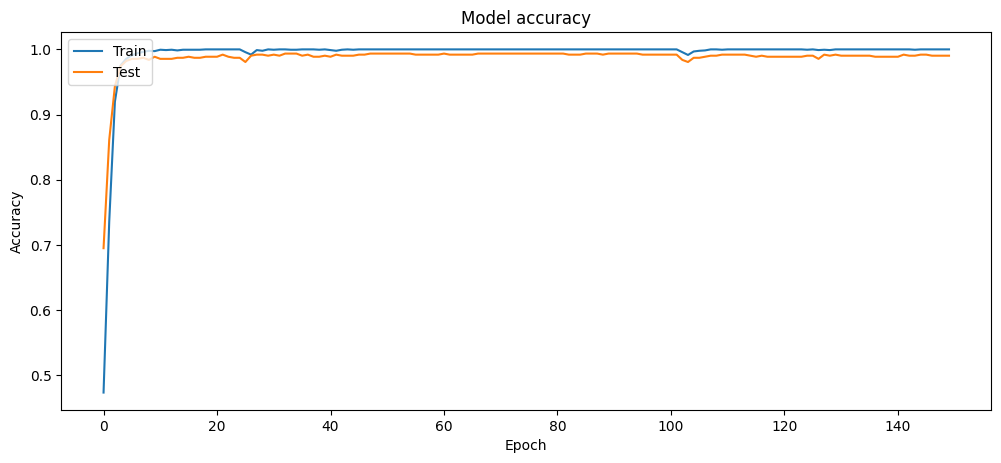

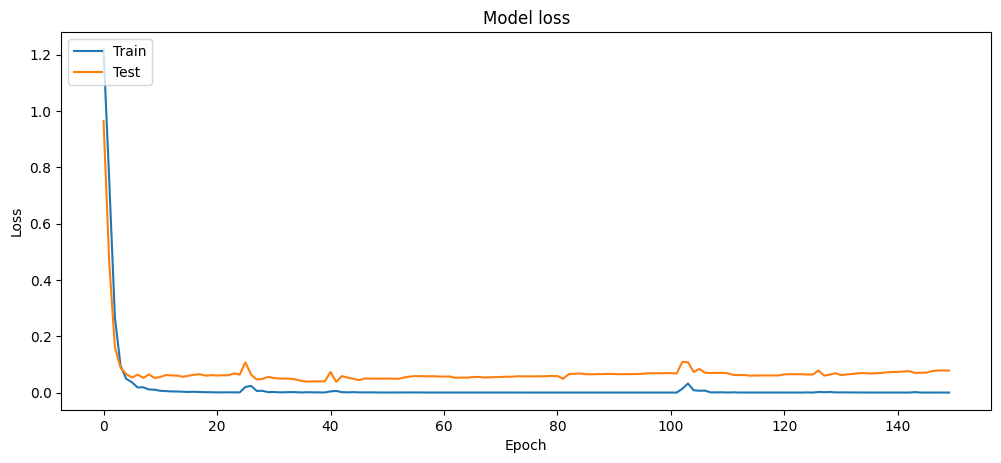

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# Predict the test data
y_pred = model.predict(X_tst)

# Reverse one-hot encoding
y_pred = [np.argmax(y, axis=None, out=None) for y in y_pred]
y_true = [np.argmax(y, axis=None, out=None) for y in y_tst]

acc = accuracy_score(y_true, y_pred)
print(acc)

In [36]:
# Verify correctness: 
# List predictions and ground truth labels side to side for visual inspection.

preds_df = pd.DataFrame(y_pred) # Store predictions in dataframe
truth_df = pd.DataFrame(y_true) # Store truth labels in dataframe
verify_df = pd.concat([preds_df, truth_df], axis=1) # Concatenate dataframes along column axis
verification = verify_df.to_csv('verification.csv', index=False) # Output to csv

verify_df

,0,0
0,1,1
1,1,1
2,1,1
3,0,0
4,2,2
...,...,...
615,1,1
616,0,0
617,3,3
618,3,3


In [41]:
for i in range(preds_df.shape[0]):
    if preds_df.values[i] != truth_df.values[i]:
        print(i)

536
